# Предсказание стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
# библиотеки работы с данными
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn
import datetime as dt

# откючаем предупреждения
import warnings
warnings.filterwarnings('ignore')

# установка настроек для отображения всех колонок при печати
pd.set_option('display.max_columns', None)

# разделение на выборки
from sklearn.model_selection import train_test_split 

# графики
import matplotlib.pyplot as plt 

# модели
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor

# стандартизация признаков
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# метрики
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from math import sqrt

## Подготовка данных

### Описание данных

**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**  
* Price — цена (евро)

### Загрузка и первичный анализ данных

Стандартным способом произведем загрузку таблицы csv, сразу установив при этом тип данных столбцов с датами как datetime  
Т.к. таблица содержит много столбцов, для большей наглядности выведем ее часть в перевернутом виде

In [2]:
df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

df.head().T

,0,1,2,3,4
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
Price,480,18300,9800,1500,3600
VehicleType,NaN,coupe,suv,small,small
RegistrationYear,1993,2011,2004,2001,2008
Gearbox,manual,manual,auto,manual,manual
Power,0,190,163,75,69
Model,golf,NaN,grand,golf,fabia
Kilometer,150000,125000,125000,150000,90000
RegistrationMonth,0,5,8,6,7
FuelType,petrol,gasoline,gasoline,petrol,gasoline


Визуально можно заметить что столбцы с датами DateCrawled и DateCreated содержат одинаковую информацию по числу (год, месяц, день) и их можно было бы объединить, избавившись от одного. Проверим:

In [3]:
arr = pd.DatetimeIndex(df['DateCrawled']).year == pd.DatetimeIndex(df['DateCreated']).year
pd.Series(arr).value_counts()

True     354343
False        26
dtype: int64

In [4]:
arr = pd.DatetimeIndex(df['DateCrawled']).month == pd.DatetimeIndex(df['DateCreated']).month
pd.Series(arr).value_counts()

True     353471
False       898
dtype: int64

Информация не подтвердилась. Столбцы DateCrawled и DateCreated имеют различия по году и месяцу. Пока что не будем их трогать.

Просмотрим основную информацию о столбцах таблицы:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


В таблице представлены столбцы 3х типов данных: дата, числовой и строковый.  


#### Анализ и первичная обработка числовых столбцов

Выведем сводку описательной статистики по числовым столбцам:

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Признак Price**

Посмотрим у скольких авто усстановлена цена в 0 евро:

In [7]:
df[df.Price == 0].Price.count()

10772

Можно предположить, что данные авто отдают даром по каким-либо причинам, что вполне может быть реальностью.  
Поэтому примем решение оставить нули в данном столбце.

In [8]:
print(df['Price'].describe())

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


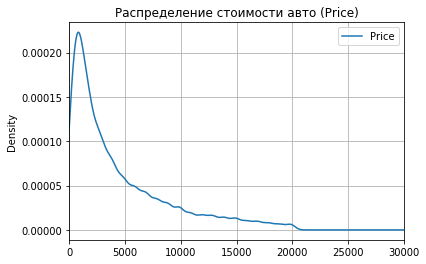

In [9]:
df.plot(y = 'Price', kind = 'density', grid = True, xlim = (-1,30000))
plt.title('Распределение стоимости авто (Price)')

plt.show()

Из быстрого анализа данных можно сделать вывод о том, что примерно 75% машин стоят меньше 6 400 $


**Признак RegistrationYear**  

По столбцу DateCrawled видим что выгрузка данных происходила в 2016 году, исходя из чего мы можем сделать вывод о том, что значения в столбце RegistrationYear (год регистрации), которые оказались больше 2016 года, - ошибочны. Также, в соответствии с популярными досками объявлений, такими как Авито и Юла, мы можем считать ошибочными также год производства, указанный как более ранний чем 1960-й.

In [10]:
pd.DatetimeIndex(df['DateCrawled']).year.max()

2016

In [11]:
pd.DatetimeIndex(df['DateCrawled']).year.min() == pd.DatetimeIndex(df['DateCrawled']).year.max()

True

Посмотрим на количество строк, не удовлетворяющих условиям рельности года выпуска авто (1960-2016 гг):

In [12]:
x = df[df['RegistrationYear'] < 1960].RegistrationYear.count() + df[df['RegistrationYear'] > 2016].RegistrationYear.count()
x

14952

In [13]:
x / df.shape[0]

0.04219330697662606

4% от размера всего датасета, это немного, поэтому можем избавиться от данных строк:

In [14]:
df = df.query('RegistrationYear > 1960 and RegistrationYear < 2016')

In [15]:
df[df['RegistrationYear'] < 1960].RegistrationYear.count() + df[df['RegistrationYear'] > 2016].RegistrationYear.count()

0

In [16]:
df.shape

(329630, 16)

**Признак RegistrationMonth**

Мы можем заметить, что в столбце с месяцем выпуска авто, содержатся нули (более 37 тысяч). Если предположить что исчисление месяцев шло с нуля то тогда кол-во месяцев получилось бы на 1 меньше (11). Но у нас их 12. Следовательно все нули - это ошибки. Мы можем предположить что так ошибочно был указан первый месяц (январь) и заменить все нули на 1. Но т.к. это всё лишь предположения о возможной причине ошибки, более корректно будет совсем избавиться от нулей.

In [17]:
df[df['RegistrationMonth'] == 0].RegistrationMonth.count()

30641

In [18]:
df = df.query('RegistrationMonth != 0')

In [19]:
df[df['RegistrationMonth'] == 0].RegistrationMonth.count()

0

In [20]:
df.shape

(298989, 16)

**Признак Power**

Как нам известно, мощность двигателя легковых авто может быть не ниже чем 11 (например, Renault Twizy) и не выше чем 500 (максимум = 3700 л.с. - у исключительных авто, относящихся к крупной спецтехнике, которые вряд ли попали в данный список + их мощность обычно измеряется в кВт или др измерениях). Посмотрим на количество строк, выбивающихся из этих характеристик и исключим такие строки

In [21]:
df.query('Power == 0').Power.count()

20876

In [22]:
df.query('Power > 500 or Power < 11').Power.count()

21416

In [23]:
df = df.query('10 < Power < 499')
df.query('Power > 500 or Power < 11').Power.count()

0

In [24]:
df.shape

(277543, 16)

**Признак NumberOfPictures**

Можно увидеть, что столбец с количеством фото полностью состоит из нулей, т.обр он для нас не несет никакой информации, следовательно мы можем избавиться от него

In [25]:
df['NumberOfPictures'].value_counts()

0    277543
Name: NumberOfPictures, dtype: int64

In [26]:
df.shape

(277543, 16)

In [27]:
df = df.drop('NumberOfPictures', axis = 1)
df.shape

(277543, 15)

**Признак PostalCode**

Почтовый индекс совершенно никак не поможет нам в построении модели, но может помешать. Удаление данного столбца не принесет никаких негативных последствий, но поможет построить более точные предсказания:

In [28]:
df = df.drop('PostalCode', axis = 1)
df.shape

(277543, 14)

#### Анализ и первичная обработка нечисловых столбцов

Выведем сводку описательной статистики по нечисловым столбцам (у нас из таких представлены столбцы только типа object):

In [29]:
df.describe(include='object')

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,274500,273883,268851,267964,277543,244019
unique,8,2,249,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,80364,217404,22705,177433,59208,217753


In [30]:
df['VehicleType'].value_counts()

sedan          80364
small          66670
wagon          56969
bus            25558
convertible    18091
coupe          13934
suv            10670
other           2244
Name: VehicleType, dtype: int64

In [31]:
df['FuelType'].value_counts() 

petrol      177433
gasoline     85266
lpg           4461
cng            470
hybrid         198
other           77
electric        59
Name: FuelType, dtype: int64

Из 6 числовых столбцов у нас имеется 4 столбца с категориальными переменными, 2 из которых могли бы быть типа boolean, т.к. содержат только по 2 значения (тип коробки передач Gearbox и была ли машина в ремонте NotRepaired).  
Обратим на это внимание во время кодирования

#### Анализ и первичная обработка столбцов с датами

К столбцам с типом datetime относятся:
* LastSeen — дата последней активности пользователя  
* DateCrawled — дата скачивания анкеты из базы  
* DateCreated — дата создания анкеты

Т.к. из этих дат невозможно вынести никакой ценной информации для будущего прогноза стоимости авто, примем решение удалить все столбцы с датами за их ненадобностью

In [32]:
df.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
NotRepaired                  object
DateCreated          datetime64[ns]
LastSeen             datetime64[ns]
dtype: object

In [33]:
df.shape

(277543, 14)

In [34]:
df = df.drop(['LastSeen', 'DateCrawled', 'DateCreated'], axis = 1)
df.shape

(277543, 11)

#### Дубликаты

Посмотрим на количество дубликатов и удалим их:

In [35]:
df.duplicated().sum()

22694

In [36]:
df = df.drop_duplicates().reset_index(drop = True)
df.duplicated().sum()

0

In [37]:
len(df)

254849

#### Пропущенные значения

In [38]:
df.isna().sum()

Price                    0
VehicleType           2961
RegistrationYear         0
Gearbox               3531
Power                    0
Model                 8330
Kilometer                0
RegistrationMonth        0
FuelType              9341
Brand                    0
NotRepaired          31649
dtype: int64

Мы видим что в целевом столбце пропуски отстуствуют, это хорошо.  
В других 5 столбцах у нас присутствует большое количество пропусков.  
С первого взгляда, можно заметить что пропуски в столбце NotRepaired могли быть связаны с тем, что авто ни разу не подвергалось ремонту, поэтому заполним их нулями:

In [39]:
df['NotRepaired'].value_counts()

no     198272
yes     24928
Name: NotRepaired, dtype: int64

In [40]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')
df['NotRepaired'].isna().sum()

0

In [41]:
df.shape

(254849, 11)

In [42]:
df.isna().sum().sum()

24163

У нас осталось много пропусков, но т.к. они находятся в категориальных переменных, мы не сможем подобрать хороший метод для их заполнения. Придётся их удалить.

In [43]:
df = df.dropna().reset_index(drop = True)
df.isna().sum().sum()

0

### Вывод 

1. В данном проекте нам необходимо решить задачу регрессии, т.к. целевая переменная, по заданию, у нас - столбец с ценой
2. В каждой строке таблицы представлена информация об одном автомобиле с его характеристиками (такими как год регистрации, пробег, мощность, тип кузова и др.)
3. Все типы данных и названия столбцов корректны изначально, кроме дат, которые были преобразованы в datetime на первом шаге при загрузке датафрейма
4. Мы избавились от несоответсующих действительности значений в столбцах, а также от ненужных столбцов с датами и почтовым индексом, от дубликатов и заменили по логике пропуски в столбце с ремонтом.

## Обучение моделей

### Линейная регрессия

#### Кодирование данных

Для линейной регрессии необходимо кодировать категориальные признаки и потом отмасштабировать.  

Для кодирования категориальных признаков с небольшим количеством значений в столбце используем метод прямого кодирования(OHE):

In [44]:
df.describe(include='object')

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,234633,234633,234633,234633,234633,234633
unique,8,2,249,7,39,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,69057,186108,19427,155182,49615,212439


In [45]:
df_edited = pd.get_dummies(df, columns=['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired'], drop_first=True)
df_edited.head()

,Price,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,9800,2004,163,grand,125000,8,jeep,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,1500,2001,75,golf,150000,6,volkswagen,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,3600,2008,69,fabia,90000,7,skoda,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
3,650,1995,102,3er,150000,10,bmw,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
4,2200,2004,109,2_reihe,150000,8,peugeot,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [46]:
df_edited.describe(include='object')

,Model,Brand
count,234633,234633
unique,249,39
top,golf,volkswagen
freq,19427,49615


#### Деление данных на целевой признак и остальные

Разделим исходные данные на признаки (фичи) и целевой признак (таргет)

In [47]:
features_lr = df_edited.drop(['Price'], axis = 1)
target_lr = df_edited['Price']

print('Размер исходного датафрейма:', df_edited.shape,
      '\nРазмер features:', features_lr.shape,
      '\nРазмер target:', target_lr.shape)

Размер исходного датафрейма: (234633, 22) 
Размер features: (234633, 21) 
Размер target: (234633,)


#### Ordinal Encoding

А для остальных категориальных столбцов с большим количеством значений применим порядковое кодирование (Ordinal Encoding):

In [48]:
encoder = OrdinalEncoder()
features_lr[['Model', 'Brand']] = pd.DataFrame(encoder.fit_transform(features_lr[['Model', 'Brand']]), 
                                               columns=['Model', 'Brand'])
features_lr.head()

,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,2004,163,117.0,125000,8,14.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,2001,75,116.0,150000,6,37.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,2008,69,101.0,90000,7,31.0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
3,1995,102,11.0,150000,10,2.0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
4,2004,109,8.0,150000,8,25.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### Деление на тренировочную и тестовую выборки
Объявим 4 переменные и запишем в них признаки и таргет обучающей выборки и тестовой выборки (для теста определим размер = 25%)

In [49]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(
    features_lr, target_lr, test_size=0.25, random_state=42)

print('Размер train:', features_train_lr.shape, target_train_lr.shape,
      '\nРазмер test:', features_test_lr.shape, target_test_lr.shape)

Размер train: (175974, 21) (175974,) 
Размер test: (58659, 21) (58659,)


#### Стандартизация данных

Мы видим, что данные имеют большой разброс, следовательно перед обучением модели линейной регрессии, нам необходимо отмасштабировать данные методом стандартизации. Для того, чтобы избежать переобучения, обучим стандартизатор на тренировочном датасете, а стандартизировать будем всё:

In [50]:
features_train_lr.columns

Index(['RegistrationYear', 'Power', 'Model', 'Kilometer', 'RegistrationMonth',
       'Brand', 'VehicleType_convertible', 'VehicleType_coupe',
       'VehicleType_other', 'VehicleType_sedan', 'VehicleType_small',
       'VehicleType_suv', 'VehicleType_wagon', 'Gearbox_manual',
       'FuelType_electric', 'FuelType_gasoline', 'FuelType_hybrid',
       'FuelType_lpg', 'FuelType_other', 'FuelType_petrol', 'NotRepaired_yes'],
      dtype='object')

In [51]:
scaler = StandardScaler()

scaler.fit(features_train_lr) 
features_train_lr = pd.DataFrame(scaler.transform(features_train_lr), columns=features_train_lr.columns)
features_test_lr = pd.DataFrame(scaler.transform(features_test_lr), columns=features_test_lr.columns)

features_train_lr.head()

,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,0.680266,0.335220,-0.490921,-0.073201,0.485360,-0.702217,-0.266582,-0.231267,-0.089681,1.550383,-0.559599,-0.199535,-0.513402,0.510927,-0.013058,-0.685406,-0.02698,-0.128899,-0.015266,0.715941,3.102652
1,0.018885,1.799868,-1.308656,0.607368,0.485360,-1.390987,-0.266582,-0.231267,-0.089681,1.550383,-0.559599,-0.199535,-0.513402,-1.957226,-0.013058,1.458989,-0.02698,-0.128899,-0.015266,-1.396764,-0.322305
2,0.845611,-0.603656,-0.927986,0.607368,0.485360,0.292673,-0.266582,-0.231267,-0.089681,1.550383,-0.559599,-0.199535,-0.513402,0.510927,-0.013058,-0.685406,-0.02698,-0.128899,-0.015266,0.715941,-0.322305
3,-1.965257,-0.040330,-0.688305,0.607368,-1.605075,-0.013447,-0.266582,-0.231267,-0.089681,1.550383,-0.559599,-0.199535,-0.513402,0.510927,-0.013058,-0.685406,-0.02698,-0.128899,-0.015266,0.715941,-0.322305
4,1.176301,0.767104,-1.365052,-0.073201,1.082627,-1.390987,-0.266582,-0.231267,-0.089681,-0.645002,-0.559599,-0.199535,1.947790,0.510927,-0.013058,1.458989,-0.02698,-0.128899,-0.015266,-1.396764,-0.322305


#### Обучение модели ЛР, получение предсказаний и их оценка

In [53]:
%%time

model_lr =  LinearRegression()
model_lr.fit(features_train_lr, target_train_lr)
prediction_lr = model_lr.predict(features_test_lr)

mse_lr_1 = mean_squared_error(target_test_lr, prediction_lr).round(5)

print('rMSE:', sqrt(mse_lr_1))

rMSE: 2848.764144493187
CPU times: user 274 ms, sys: 156 ms, total: 430 ms
Wall time: 433 ms


#### ЛР (с зачищенными нулями в таргете)
Проделаем все те же самые шаги но с удаленными из таргета нулями, чтобы посмотреть как изменятся показатели метрик качества в итоге.  
1. Удаляем нули в таргете (столбец Price)

In [54]:
df.query('Price == 0').Price.count()

2951

In [55]:
df_clean = df.query('Price != 0')
df_clean.query('Price == 0').Price.count()

0

In [56]:
df_clean.isna().sum().sum()

0

2. Ohe-кодирование столбцов с малым кол-вом значений категорий:

In [57]:
df_clean = pd.get_dummies(df_clean, columns=['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired'], drop_first=True)
df_clean.head()

,Price,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,9800,2004,163,grand,125000,8,jeep,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,1500,2001,75,golf,150000,6,volkswagen,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,3600,2008,69,fabia,90000,7,skoda,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
3,650,1995,102,3er,150000,10,bmw,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
4,2200,2004,109,2_reihe,150000,8,peugeot,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


3. Деление датафрейма на тагрет и фичи

In [58]:
features_lr = df_clean.drop(['Price'], axis = 1)
target_lr = df_clean['Price']

print('Размер исходного датафрейма:', df_clean.shape,
      '\nРазмер features:', features_lr.shape,
      '\nРазмер target:', target_lr.shape)

Размер исходного датафрейма: (231682, 22) 
Размер features: (231682, 21) 
Размер target: (231682,)


4. Порядковое кодирование остальных категориальных столбцов:

In [59]:
encoder = OrdinalEncoder()
encoder.fit(features_lr[['Model', 'Brand']])
features_lr[['Model', 'Brand']] = encoder.transform(features_lr[['Model', 'Brand']])
features_lr.head()

,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,2004,163,117.0,125000,8,14.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,2001,75,116.0,150000,6,37.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
2,2008,69,101.0,90000,7,31.0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
3,1995,102,11.0,150000,10,2.0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
4,2004,109,8.0,150000,8,25.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


5. Деление на тестовую и тренировочную выборки

In [60]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(
    features_lr, target_lr, test_size=0.25, random_state=42)

print('Размер train:', features_train_lr.shape, target_train_lr.shape,
      '\nРазмер test:', features_test_lr.shape, target_test_lr.shape)

Размер train: (173761, 21) (173761,) 
Размер test: (57921, 21) (57921,)


6. Масштабирование признаков методом стандартизации:

In [61]:
scaler.fit(features_train_lr) 
features_train_lr = pd.DataFrame(scaler.transform(features_train_lr), columns=features_train_lr.columns)
features_test_lr = pd.DataFrame(scaler.transform(features_test_lr), columns=features_test_lr.columns)

features_train_lr.head()

,RegistrationYear,Power,Model,Kilometer,RegistrationMonth,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
0,1.006817,-0.004056,0.117210,-2.661943,-0.409538,1.286533,-0.266729,-0.231147,-0.087023,-0.647142,-0.559605,-0.200635,-0.510946,-1.955543,-0.014194,-0.687024,-0.026507,-0.129685,-0.015733,0.717991,-0.318793
1,-1.476082,-1.356222,-0.080201,-0.071791,0.785242,-0.782041,-0.266729,-0.231147,-0.087023,-0.647142,1.786974,-0.200635,-0.510946,0.511367,-0.014194,-0.687024,-0.026507,-0.129685,-0.015733,0.717991,-0.318793
2,-0.648449,1.836393,1.188870,-0.753410,-1.305622,-0.015902,-0.266729,-0.231147,-0.087023,1.545255,-0.559605,-0.200635,-0.510946,-1.955543,-0.014194,-0.687024,-0.026507,-0.129685,-0.015733,0.717991,-0.318793
3,0.675764,2.662717,0.822249,-1.844000,-0.708232,0.290553,3.749130,-0.231147,-0.087023,-0.647142,-0.559605,-0.200635,-0.510946,0.511367,-0.014194,-0.687024,-0.026507,-0.129685,-0.015733,0.717991,-0.318793
4,-0.979502,-0.004056,-0.686536,-0.071791,-0.409538,-0.015902,-0.266729,-0.231147,-0.087023,1.545255,-0.559605,-0.200635,-0.510946,0.511367,-0.014194,-0.687024,-0.026507,-0.129685,-0.015733,0.717991,-0.318793


7. Обучение модели ЛР, получение и оценка предсказаний

In [62]:
%%time

model_lr =  LinearRegression()
model_lr.fit(features_train_lr, target_train_lr)
prediction_lr = model_lr.predict(features_test_lr)

mse_lr_2 = mean_squared_error(target_test_lr, prediction_lr).round(5)

print('rMSE:', sqrt(mse_lr_2))

rMSE: 2805.098406895915
CPU times: user 220 ms, sys: 98.1 ms, total: 318 ms
Wall time: 296 ms


После зачистки нулей в таргете качество предсказания модели немного улучшилось

### CatBoost

CatBoost — библиотека градиентного бустинга. Применяет различные техники кодирования категориальных признаков (LabelEncoding, One-Hot Encoding), поэтому кодировать заранее не придется. 

Столбцы со строковым типом данных конвертируем в категориальный тип:

In [63]:
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].astype('category')
df.dtypes

Price                   int64
VehicleType          category
RegistrationYear        int64
Gearbox              category
Power                   int64
Model                category
Kilometer               int64
RegistrationMonth       int64
FuelType             category
Brand                category
NotRepaired          category
dtype: object

Определим список категориальных столбцов в отдельную переменную

In [64]:
cat_cols = df.select_dtypes(include='category').columns
cat_cols

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

Разделим датафрейм на тренирвочный и тестовый:

In [65]:
features_train_cb, features_test_cb, target_train_cb, target_test_cb = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=12345)

print('Размер train:', features_train_cb.shape, target_train_cb.shape,
      '\nРазмер test:', features_test_cb.shape, target_test_cb.shape)

Размер train: (175974, 10) (175974,) 
Размер test: (58659, 10) (58659,)


In [66]:
train_pool = Pool(features_train_cb, 
                  target_train_cb, 
                  cat_features=cat_cols)
test_pool = Pool(features_test_cb, 
                 cat_features=cat_cols) 

Обучим модель CatBoost на тренировочных данных (всего итераций установим = 200 и будем выводить каждый 10й результат) и подсчитаем время выполнения операции:

In [67]:
%%time

model_cb = CatBoostRegressor(loss_function="RMSE", 
                          iterations=200, 
                          depth=4, 
                          verbose=10, 
                          random_seed=12345)

model_cb.fit(train_pool)

print('Время обучения:')

0:	learn: 4617.3150864	total: 455ms	remaining: 1m 30s
10:	learn: 3883.4847886	total: 4.05s	remaining: 1m 9s
20:	learn: 3369.1277948	total: 7.65s	remaining: 1m 5s
30:	learn: 3010.9166795	total: 11.1s	remaining: 1m
40:	learn: 2747.1634751	total: 14.4s	remaining: 56s
50:	learn: 2551.6203012	total: 17.7s	remaining: 51.8s
60:	learn: 2412.4316685	total: 20.9s	remaining: 47.7s
70:	learn: 2304.6356931	total: 24.3s	remaining: 44.2s
80:	learn: 2224.7438618	total: 27.7s	remaining: 40.7s
90:	learn: 2158.7647265	total: 31.1s	remaining: 37.2s
100:	learn: 2108.6923232	total: 33.9s	remaining: 33.2s
110:	learn: 2071.6516008	total: 36.9s	remaining: 29.6s
120:	learn: 2042.8125747	total: 39.8s	remaining: 26s
130:	learn: 2019.4116266	total: 42.9s	remaining: 22.6s
140:	learn: 1999.0054778	total: 46.3s	remaining: 19.4s
150:	learn: 1982.4144540	total: 49.6s	remaining: 16.1s
160:	learn: 1966.6388086	total: 53.3s	remaining: 12.9s
170:	learn: 1953.2137363	total: 56.5s	remaining: 9.59s
180:	learn: 1941.5615225	to

Получим предсказания модели CatBoost и посмотрим на время выполнения и метрику качества rMSE:

In [68]:
%%time

preds_cb = model_cb.predict(test_pool)

mse_cb = mean_squared_error(target_test_cb, preds_cb).round(5)

print('rMSE:', sqrt(mse_cb),
     '\nВремя предсказания:')

rMSE: 1906.1613929308296 
Время предсказания:
CPU times: user 79.9 ms, sys: 653 µs, total: 80.5 ms
Wall time: 20.7 ms


Результат оказался хуже чем у линейной регрессии, и процесс шел намного дольше

In [69]:
data = pd.DataFrame(
    [['Linear Refression', sqrt(mse_lr_1), '<1', '<1'],
    ['CatBoost', sqrt(mse_cb), '65', '<1']], 
    columns=['Модель', 'rMSE', 't обучения, сек', 't предсказания, сек'])
data

,Модель,rMSE,"t обучения, сек","t предсказания, сек"
0,Linear Refression,2848.764144,<1,<1
1,CatBoost,1906.161393,65,<1


#### CatBoost (после зачистки нулей в таргете)

Зачистим нули и переделаем всё еще раз, чтобы посмотреть как изменятся результаты:

In [70]:
df_clean = df.query('Price != 0')
df_clean.query('Price == 0').Price.count()

0

In [71]:
features_train_cb, features_test_cb, target_train_cb, target_test_cb = train_test_split(
    df_clean.drop('Price', axis=1), df_clean.Price, test_size=0.25, random_state=12345)

print('Размер train:', features_train_cb.shape, target_train_cb.shape,
      '\nРазмер test:', features_test_cb.shape, target_test_cb.shape)

Размер train: (173761, 10) (173761,) 
Размер test: (57921, 10) (57921,)


In [72]:
train_pool = Pool(features_train_cb, 
                  target_train_cb, 
                  cat_features=cat_cols)
test_pool = Pool(features_test_cb, 
                 cat_features=cat_cols) 

In [73]:
%%time

model_cb = CatBoostRegressor(loss_function="RMSE", 
                          iterations=200, 
                          depth=4, 
                          verbose=10, 
                          random_seed=12345)

model_cb.fit(train_pool)

print('Время обучения:')

0:	learn: 4591.1319085	total: 380ms	remaining: 1m 15s
10:	learn: 3851.3669286	total: 3.98s	remaining: 1m 8s
20:	learn: 3336.7738091	total: 7.57s	remaining: 1m 4s
30:	learn: 2970.5665777	total: 11.3s	remaining: 1m 1s
40:	learn: 2706.2172522	total: 14.5s	remaining: 56.4s
50:	learn: 2512.4053834	total: 17.9s	remaining: 52.4s
60:	learn: 2366.1694657	total: 21.3s	remaining: 48.6s
70:	learn: 2255.5791880	total: 24.8s	remaining: 45.1s
80:	learn: 2172.2750951	total: 28.4s	remaining: 41.7s
90:	learn: 2103.8396280	total: 31.4s	remaining: 37.6s
100:	learn: 2052.3677229	total: 34.2s	remaining: 33.5s
110:	learn: 2012.2957523	total: 37.2s	remaining: 29.8s
120:	learn: 1982.2412409	total: 40.5s	remaining: 26.4s
130:	learn: 1955.8969453	total: 43.8s	remaining: 23.1s
140:	learn: 1936.3446124	total: 47.2s	remaining: 19.7s
150:	learn: 1918.2143153	total: 50.7s	remaining: 16.4s
160:	learn: 1902.7128051	total: 54.1s	remaining: 13.1s
170:	learn: 1888.3828833	total: 57.4s	remaining: 9.73s
180:	learn: 1875.594

In [77]:
%%time

preds_cb_2 = model_cb.predict(test_pool)

mse_cb_2 = mean_squared_error(target_test_cb, preds_cb_2).round(5)

print('rMSE:', sqrt(mse_cb_2),
     '\nВремя предсказания:')

rMSE: 1860.7244631728795 
Время предсказания:
CPU times: user 74.3 ms, sys: 8.3 ms, total: 82.6 ms
Wall time: 21.3 ms


Метрика по CatBoost улучшилась от зачистки нулей в таргете.

### Дерево решений

Для подбора параметров лучшей модели дерева решений воспользуемся RandomizedSearchCV:

In [78]:
def rmse(target, predict):
    return mean_squared_error(target, predict) ** 0.5

In [83]:
%%time

rmse_score = make_scorer(rmse, greater_is_better = False)

params = {
    'max_depth' : range(1, 21, 1),
    'min_samples_leaf' : [2, 21, 2]
}

grid_tree = RandomizedSearchCV(DecisionTreeRegressor(random_state = 12345), params, 
                                 cv = 5, n_iter=10, scoring=rmse_score)
grid_tree.fit(features_train_lr, target_train_lr)

print('\n\nЛучшие параметры дерева решений:', grid_tree.best_params_,
     '\n\nВремя выполнения кода:')



Лучшие параметры дерева решений: {'min_samples_leaf': 21, 'max_depth': 19} 

Время выполнения кода:
CPU times: user 33 s, sys: 0 ns, total: 33 s
Wall time: 33.6 s


In [84]:
%%time

preds_tree = grid_tree.predict(features_test_lr)

rmse_tree = rmse(target_test_lr, preds_tree)

print('rMSE:', rmse_tree,
     '\nВремя предсказания:')

rMSE: 1761.6016609370051 
Время предсказания:
CPU times: user 20.9 ms, sys: 0 ns, total: 20.9 ms
Wall time: 18.8 ms


Результаты получились приемлемыми, а также модель дерева решений очень быстро обучилась и посчитала предсказания

### LightGBM

LightGBM — это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом. Работает с категориальными признаками напрямую.

Произведем деление датафрейма на обучающую и тестовую выборки:

In [85]:
features_train_lgb, features_test_lgb, target_train_lgb, target_test_lgb = train_test_split(
    df.drop('Price', axis=1), df.Price, test_size=0.25, random_state=12345)

print('Размер train:', features_train_lgb.shape, target_train_lgb.shape,
      '\nРазмер test:', features_test_lgb.shape, target_test_lgb.shape)

Размер train: (175974, 10) (175974,) 
Размер test: (58659, 10) (58659,)


Определим в 2 переменных обучающий и тестовый наборы для передачи в качестве параметров в модель LightGBM:

In [86]:
train_data = lgb.Dataset(features_train_lgb, target_train_lgb)
test_data = lgb.Dataset(features_test_lgb, target_test_lgb)

Обучим модель LightGBM и посмотрим на время выполнения ячейки:

* gbdt - traditional Gradient Boosting Decision Tree
* l1 - это mean_absolute_error, а l2 - mean_squared_error  
* кол-во итераций num_boost_round установим в 200
* будем выводить также как в кэтбусте каждый 10й результат (verbose_eval)

In [88]:
%%time

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

model_lgb = lgb.train(params,
                train_data,
                num_boost_round=100,
                      verbose_eval=10,
                valid_sets=test_data)

[10]	valid_0's l2: 1.11039e+07	valid_0's l1: 2584.22
[20]	valid_0's l2: 6.59407e+06	valid_0's l1: 1916.79
[30]	valid_0's l2: 4.64693e+06	valid_0's l1: 1538.1
[40]	valid_0's l2: 3.7685e+06	valid_0's l1: 1328.87
[50]	valid_0's l2: 3.33598e+06	valid_0's l1: 1211.04
[60]	valid_0's l2: 3.10322e+06	valid_0's l1: 1143.84
[70]	valid_0's l2: 2.975e+06	valid_0's l1: 1104.43
[80]	valid_0's l2: 2.89824e+06	valid_0's l1: 1079.58
[90]	valid_0's l2: 2.84904e+06	valid_0's l1: 1064.68
[100]	valid_0's l2: 2.81409e+06	valid_0's l1: 1054.33
CPU times: user 5min 6s, sys: 1.82 s, total: 5min 8s
Wall time: 5min 11s


Получим предсказания модели LightGBM и посмотрим на RMSE и время выполнения ячейки:

In [92]:
%%time

preds_lgb = model_lgb.predict(features_test_lgb, num_iteration=model_lgb.best_iteration)

mse_lgb = mean_squared_error(target_test_lgb, preds_lgb).round(5)

print('\nrMSE:', sqrt(mse_lgb))


rMSE: 1677.525122858075
CPU times: user 956 ms, sys: 0 ns, total: 956 ms
Wall time: 859 ms


#### LightGBM (после зачистки нулей в таргете)

Переделаем всё еще раз на зачищенных от нуля в таргете данных, чтобы посмотреть как изменятся результаты:

In [93]:
train_data = lgb.Dataset(features_train_cb, target_train_cb)
test_data = lgb.Dataset(features_test_cb, target_test_cb)

In [94]:
%%time

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

model_lgb = lgb.train(params,
                train_data,
                num_boost_round=100,
                      verbose_eval=10,
                valid_sets=test_data)

[10]	valid_0's l2: 1.12236e+07	valid_0's l1: 2595.75
[20]	valid_0's l2: 6.58316e+06	valid_0's l1: 1917.03
[30]	valid_0's l2: 4.56206e+06	valid_0's l1: 1529.72
[40]	valid_0's l2: 3.64418e+06	valid_0's l1: 1316.91
[50]	valid_0's l2: 3.18774e+06	valid_0's l1: 1197.59
[60]	valid_0's l2: 2.94016e+06	valid_0's l1: 1128.83
[70]	valid_0's l2: 2.79882e+06	valid_0's l1: 1087.55
[80]	valid_0's l2: 2.71817e+06	valid_0's l1: 1062.98
[90]	valid_0's l2: 2.66373e+06	valid_0's l1: 1046.46
[100]	valid_0's l2: 2.62659e+06	valid_0's l1: 1036.06
CPU times: user 12 s, sys: 78.3 ms, total: 12.1 s
Wall time: 12.2 s


In [95]:
%%time

preds_lgb_2 = model_lgb.predict(features_test_lgb, num_iteration=model_lgb.best_iteration)

mse_lgb_2 = mean_squared_error(target_test_lgb, preds_lgb).round(5)

print('Best Interation:', model_lgb.best_iteration,
     '\nrMSE:', sqrt(mse_lgb))

Best Interation: 0 
rMSE: 1677.525122858075
CPU times: user 977 ms, sys: 1.58 ms, total: 979 ms
Wall time: 928 ms


Время выполнения оказалось больше, чем у Catboost, но результат выполнения оказался самым приемлемым среди всех моделей

## Анализ моделей

Проверим адекватность полученных предсказаний моделей, сравнив их метрики RMSE с ошибкой на простой базисной модели:

In [96]:
features_train, features_test, target_train, target_test = train_test_split(
    df_clean.drop('Price', axis=1), df_clean.Price, test_size=0.25, random_state=12345)

print('Размер train:', features_train.shape, target_train.shape,
      '\nРазмер test:', features_test.shape, target_test.shape)

Размер train: (173761, 10) (173761,) 
Размер test: (57921, 10) (57921,)


In [97]:
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)

rmse_dummy = mean_squared_error(target_test, dummy_predict) ** 0.5

print('rMSE:', rmse_dummy)

rMSE: 5004.589561842067


Все модели оказались лучше, чем простейший прогноз

In [99]:
data = pd.DataFrame(
    [['Linear Refression', sqrt(mse_lr_1), '<1', '<1'],
    ['Desicion Tree', rmse_tree, '33', '<1'],
    ['CatBoost', sqrt(mse_cb_2), '65', '<1'],
    ['LightGBM', sqrt(mse_lgb_2), '157', '<3'],
    ['Dummy', rmse_dummy, '-', '-']], 
    columns=['Модель', 'rMSE', 't обучения, сек', 't предсказания, сек'])
data                       

,Модель,rMSE,"t обучения, сек","t предсказания, сек"
0,Linear Refression,2848.764144,<1,<1
1,Desicion Tree,1761.601661,33,<1
2,CatBoost,1860.724463,65,<1
3,LightGBM,1677.525123,157,<3
4,Dummy,5004.589562,-,-


## Вывод

Самой быстрой и точной оказалась модель Дерево Решений. 
Она дала почти самый близкий к реальной цене автомобиля результат за совокупное время менее 33 секунды.

Нужно все-таки отметить, что наиболее точный результат дали предсказания лучшей модели LightGBM, однако время ее обучения оставляет желать лучшего, а оно нам очень важно.